# Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr

In [3]:
scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

# Load Data

In [4]:
rna_meta_ad = pickle.load(open("data/rna_meta_ad.p", "rb"))

# Index each metacell
rna_meta_ad.obs['metacell'] = range(99)

# Sort metacells
rna_meta_ad = rna_meta_ad[rna_meta_ad.obs.sort_values('celltype').index]

In [5]:
# Load in gene scores
gene_scores_df = pd.read_csv('data/cd34_gene_scores.csv', index_col=0)
gene_scores_df = gene_scores_df.loc[rna_meta_ad.obs.index]

In [6]:
# Add gene scores dataframe into metacell anndata object
rna_meta_ad.obsm['gene_scores'] = gene_scores_df

In [7]:
# PCA
sc.tl.pca(rna_meta_ad)

# Compute neighborhood graph
sc.pp.neighbors(rna_meta_ad, n_pcs=30, n_neighbors=18)

In [8]:
rna_meta_ad

AnnData object with n_obs × n_vars = 99 × 12464
    obs: 'celltype', 'metacell'
    uns: 'pca', 'neighbors'
    obsm: 'gene_scores', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

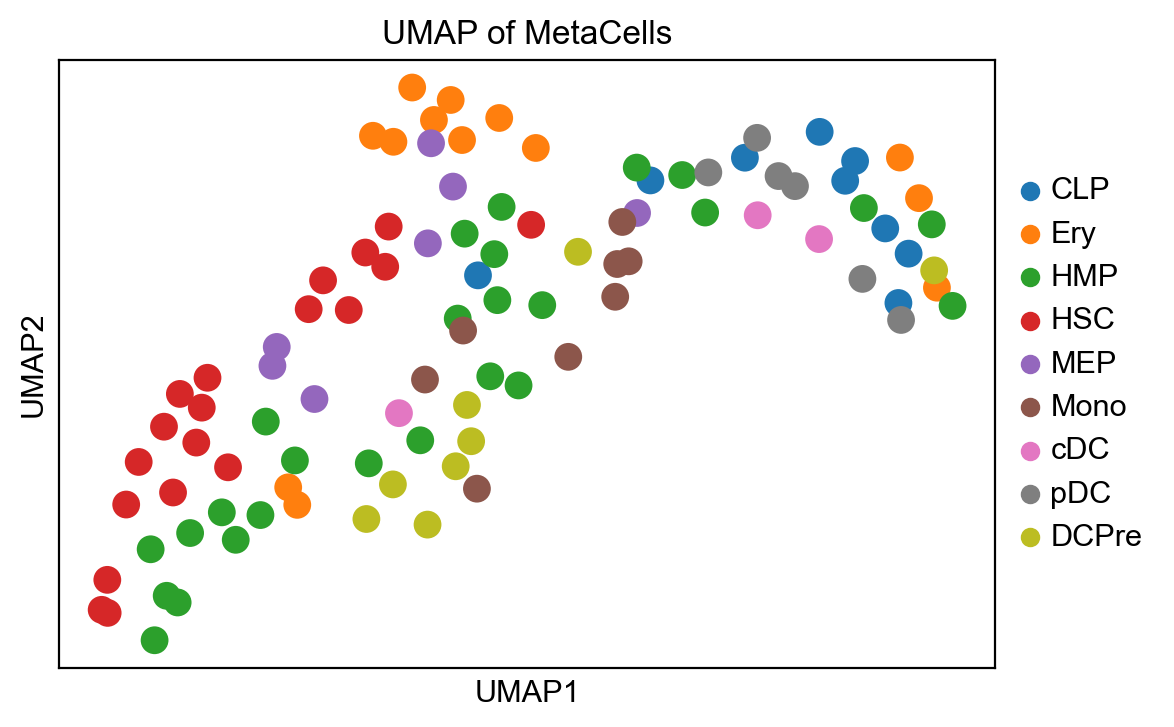

In [9]:
sc.tl.leiden(rna_meta_ad)
sc.tl.umap(rna_meta_ad)
sc.pl.umap(rna_meta_ad, color='celltype', size=400,
           title="UMAP of MetaCells")

# Pseudotime Kernel

In [10]:
# Pre-Processing
rna_meta_ad.layers["spliced"] = rna_meta_ad.X
rna_meta_ad.layers["unspliced"] = rna_meta_ad.X
scv.pp.moments(rna_meta_ad, n_pcs=30, n_neighbors=18)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [11]:
from cellrank.tl.kernels import CytoTRACEKernel

# Initialize pseudotime kernel
ctk = CytoTRACEKernel(rna_meta_ad)

Computing CytoTRACE score with `12464` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)


In [12]:
ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)

Computing transition matrix based on `ct_pseudotime`


  0%|          | 0/99 [00:00<?, ?cell/s]

    Finish (0:00:00)


<CytoTRACEKernel>

# CellRank

In [13]:
from cellrank.tl.estimators import GPCCA

g = GPCCA(ctk)
print(g)

GPCCA[n=99, kernel=<CytoTRACEKernel[dnorm=False, scheme=soft, b=10.0, nu=0.5]>]


In [14]:
# Compute matrix decomposition
g.compute_schur(n_components=9)

# Compute macrostates
g.compute_macrostates(n_states=5, n_cells=10)

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Computing `5` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


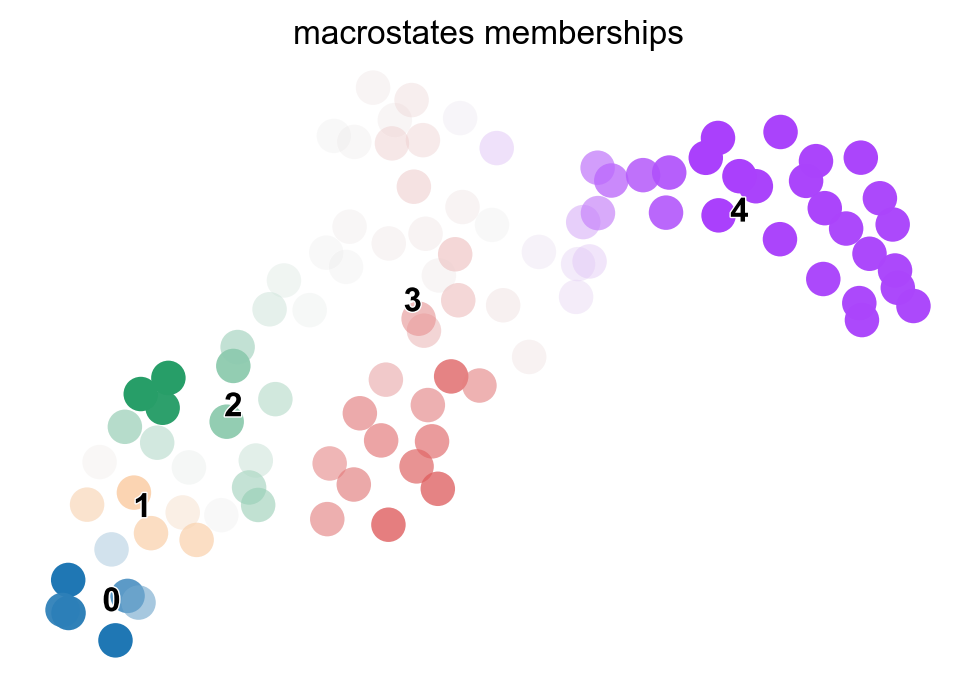

In [15]:
g.plot_macrostates()

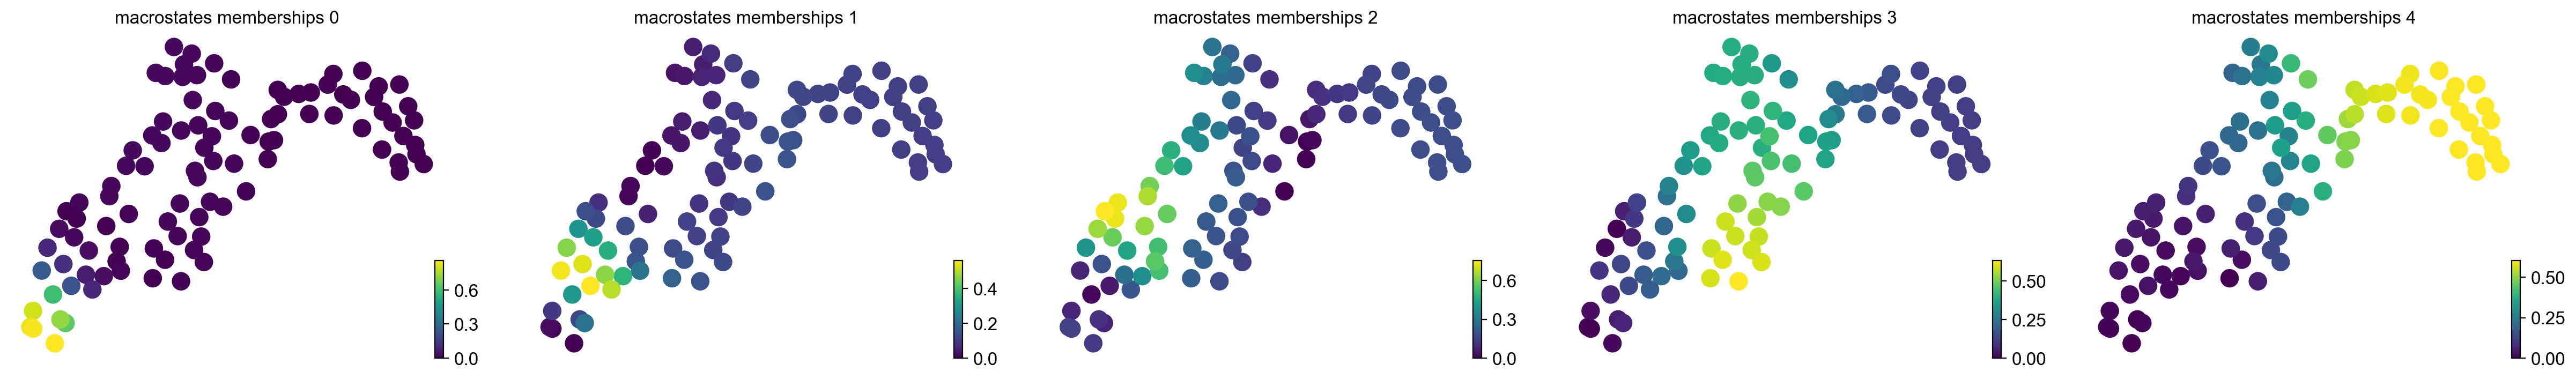

In [16]:
g.plot_macrostates(same_plot=False)

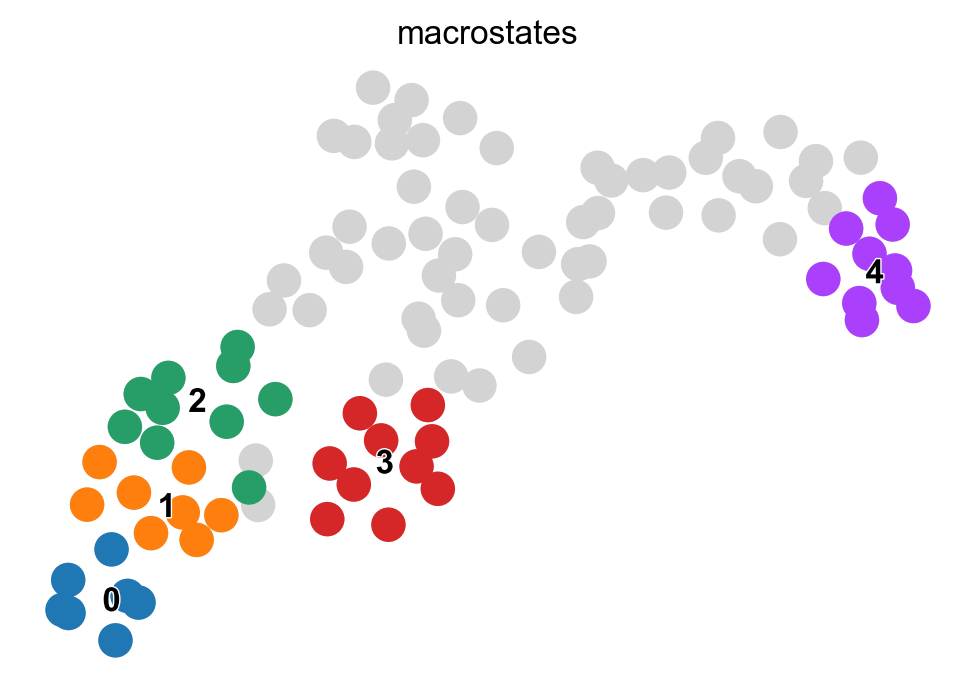

In [17]:
g.plot_macrostates(discrete=True)

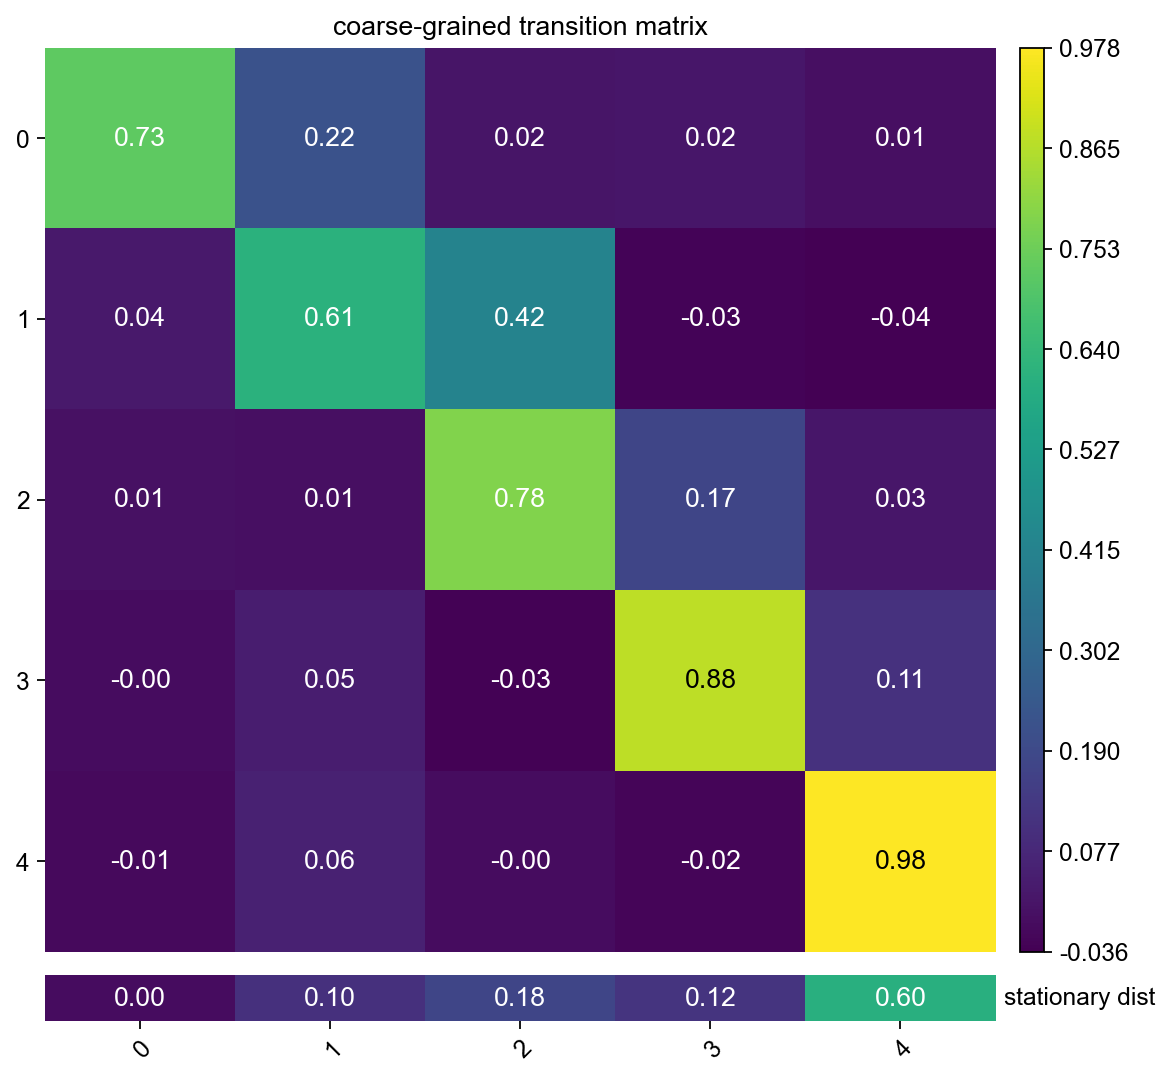

In [18]:
g.plot_coarse_T()

In [19]:
# Predict terminal states
g.predict(n_cells=10, stability_threshold=0.8)

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


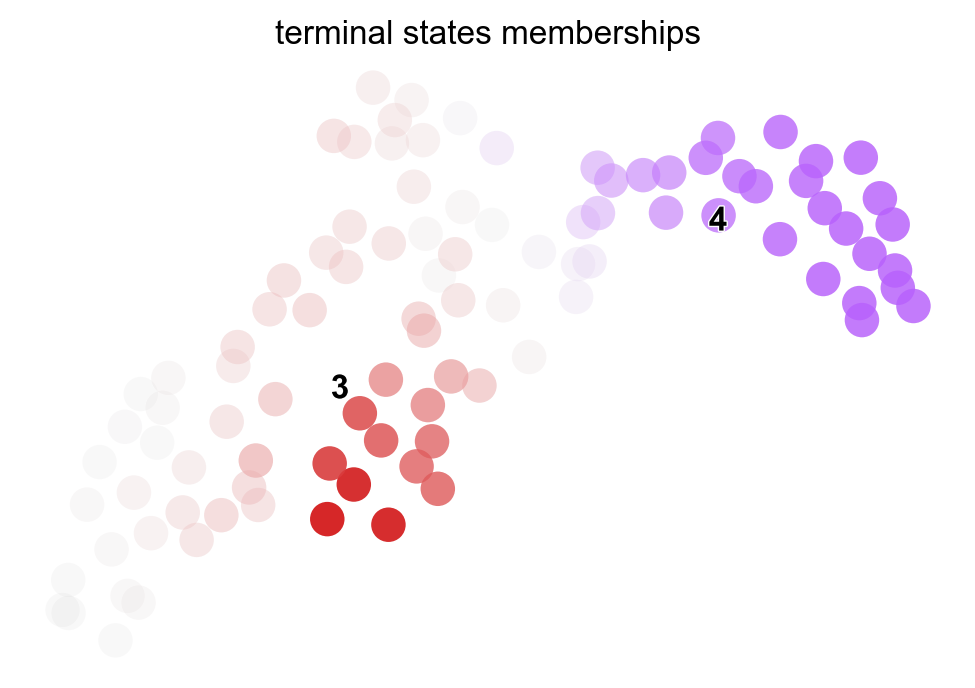

In [20]:
g.plot_terminal_states()